In [5]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pyccl
import math
import os

import sys
sys.path.append("./simulation_code/")
from simulate_des_maps import *

from coefficient import * 

os.environ["PATH"]='/home/ngrewal/flask/flask/bin:'+os.environ["PATH"]

# Import the NaMaster python wrapper
import pymaster as nmt

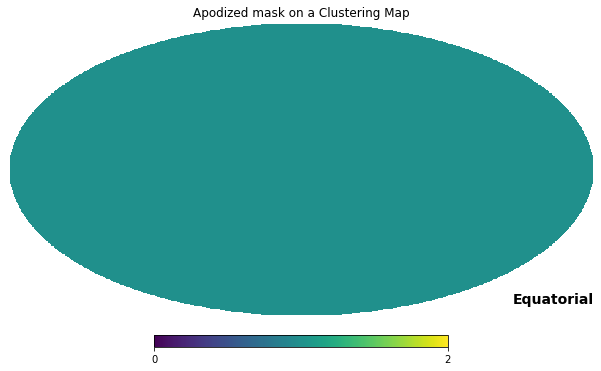

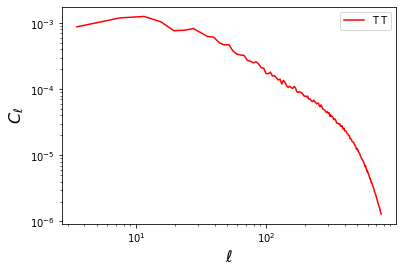

In [2]:
#  Simple example showcasing the use of NaMaster to compute the pseudo-Cl
#  estimator of the angular cross-power spectrum of a spin-0 field

# HEALPix resolution parameter used here
nside = 256
smoothing = 20 #arcmin

# Build clustering map
c_map = simulate_des_maps(0.3, 0.8, smoothing, nside,nmax=1)[0][0]

# Read mask and apodize it on a scale of ~1deg
#mask = nmt.mask_apodization(hp.read_map("mask.fits", verbose=False),1., apotype="Smooth")
#mask = nmt.mask_apodization(c_map,aposize=40) #this changes with mask
mask = np.ones(len(c_map))

hp.mollview(mask, coord=['G', 'C'], title='Apodized mask on a Clustering Map')
plt.show()

# Read healpix maps and initialize a spin-0
f_0 = nmt.NmtField(mask, [c_map])

# Initialize binning scheme with 4 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 4)

# Compute MASTER estimator
# spin-0 x spin-0
cl_00 = nmt.compute_full_master(f_0, f_0, b)

# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_00[0], 'r-', label='T T')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

In [6]:
## Simulation Variables
thr_ct = 10                                   # threshold count
nside = 256                                   # number of pixels on each side of the map
smoothing=20                                  # map scale
N = 12*nside*nside                            # total number of pixels
aposize = 1                                   # size of masks (in degrees)
b = nmt.NmtBin.from_nside_linear(nside, 4)    # apply binning with 4 ells per bandpower

## Analysis Variables
itr = 2000                                    # number of iterations
map_len = 9                                   # sum of the number of lensing and clustering redshift bins
array_len = map_len*thr_ct*3                  # length of covariance array - multiply by 3 for 3 MFs
Cl_len = map_len*b.get_n_bands()              # length of Cls 

In [60]:
# calculate C_l for any map with masking applied

def C_l(map_,smoothing, nside, aposize):
        
    mask = np.ones(len(map_))                    # build mask
    f_0 = nmt.NmtField(mask, [map_])              # initialize spin-0
    cl_00 = nmt.compute_full_master(f_0, f_0, b)  # computer MASTER estimator
    
    return cl_00[0]

In [61]:
# calculate and concatenate C_l for clustering and lensing maps

def C_l_2maps(c_map,l_map,smoothing, nside, aposize):
    
    Cl = np.zeros((len(c_map)+len(l_map),191)) # how to avoid hardcoding length of C_l?
    for i in range(len(c_map)):
        Cl[i] = C_l(c_map[i],smoothing,nside,aposize)  # clustering map
    for j in range(len(l_map)):
        Cl[i+j] = C_l(l_map[j],smoothing,nside,aposize)  # lensing map
    return Cl

In [63]:
%%time

# Calculate MFs and C_ls for clustering and lensing maps
v_all_fixed = np.zeros((itr,array_len+Cl_len)) 
for i in range(itr):
    # simulate maps
    clustering_maps, lensing_maps = simulate_des_maps(0.3, 0.8, smoothing, nside)
    # calc MFs
    v_fixed, v0_fixed, v1_fixed, v2_fixed = calc_mf_2maps(clustering_maps,lensing_maps,thr_ct,N)
    # calc C_ls
    CL = C_l_2maps(clustering_maps,lensing_maps,smoothing, nside, aposize)
    # combine into one array
    v_all_fixed[i] = np.concatenate((v0_fixed.flatten(),v1_fixed.flatten(),v2_fixed.flatten(),CL.flatten()))
    print(i)

v_all_fixed.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
CPU times: user 5d 11h 2min 37s, sys: 23min 13s, total: 5d 11h 25min 51s
Wall time: 1d 7h 50min 16s


(2000, 1989)

In [10]:
#'''

from tempfile import TemporaryFile
itr_2000 = TemporaryFile()

# save data
#np.save(itr_2000,v_all_fixed)


# load data
_ = itr_2000.seek(0)
np.load(itr_2000,allow_pickle=True)

#'''

OSError: Failed to interpret file <_io.BufferedRandom name=47> as a pickle

(1989, 1989)


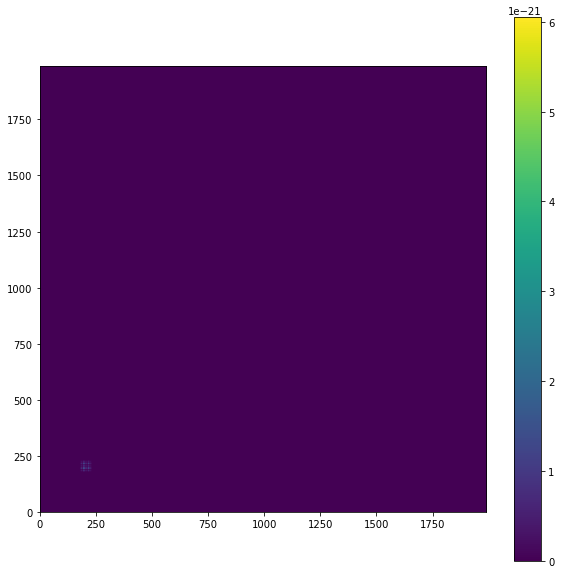

In [97]:
# covariance
cov = np.cov((v_all_fixed.transpose()))
print(cov.shape)
fig, ax = plt.subplots(figsize=(10, 10))
ax_ = ax.imshow((abs(cov)),origin='lower')
ax_
fig.colorbar(ax_);

(1989, 1989)


<ipython-input-98-ce3d4e2a7462>:5: RuntimeWarning: divide by zero encountered in log
  ax_ = ax.imshow(np.log(abs(cov)),origin='lower')


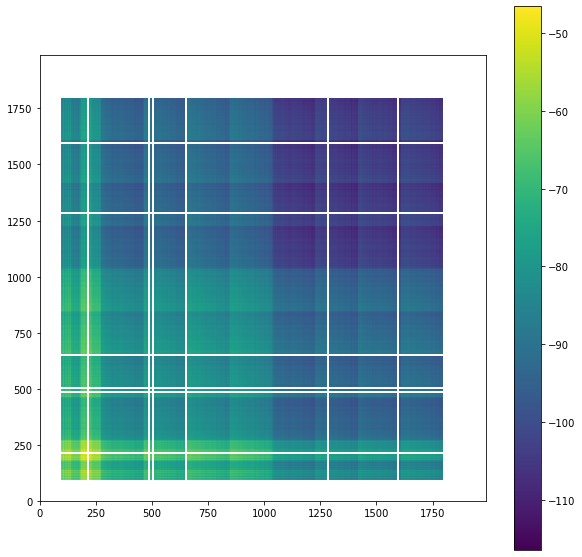

In [98]:
# covariance - logplot
cov = np.cov((v_all_fixed.transpose()))
print(cov.shape)
fig, ax = plt.subplots(figsize=(10, 10))
ax_ = ax.imshow(np.log(abs(cov)),origin='lower')
fig.colorbar(ax_);

(270, 270)


<ipython-input-99-d6956781c391>:11: RuntimeWarning: divide by zero encountered in log
  ax_ = ax.imshow(np.log(abs(cov)),origin='lower')


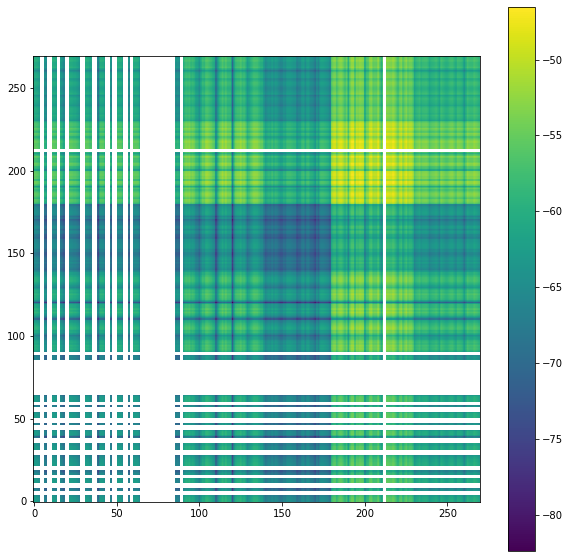

In [99]:
# covariance - logplots - Cls, MFs separate

# split array into Cls and MFs
MFs = v_all_fixed.transpose()[0:array_len]
Cls = v_all_fixed.transpose()[array_len:len(v_all_fixed[0])]

# MFs
cov = np.cov((MFs))
print(cov.shape)
fig, ax = plt.subplots(figsize=(10, 10))
ax_ = ax.imshow(np.log(abs(cov)),origin='lower')
fig.colorbar(ax_);

(1719, 1719)


<ipython-input-100-d14038014df0>:5: RuntimeWarning: divide by zero encountered in log
  ax_ = ax.imshow(np.log(abs(cov)),origin='lower')


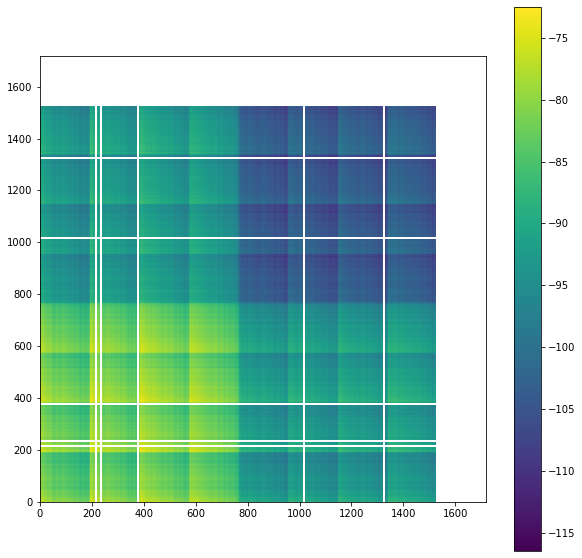

In [100]:
# Cls
cov = np.cov((Cls))
print(cov.shape)
fig, ax = plt.subplots(figsize=(10, 10))
ax_ = ax.imshow(np.log(abs(cov)),origin='lower')
fig.colorbar(ax_);

(1989, 1989)


<ipython-input-119-9086131bc98a>:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(cov)),origin='lower')


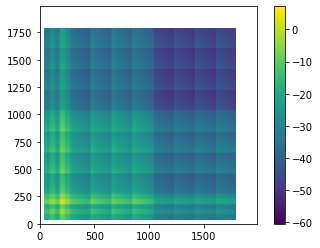

In [119]:
# covariance - make it bigger - OLD
cov = np.cov((v_all_fixed.transpose()))
print(cov.shape)
plt.imshow(np.log(abs(cov)),origin='lower')
plt.colorbar();